In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set_palette("Set2")

In [2]:
from dotenv import load_dotenv
from ephys_queries import db_setup_core, select_spike_times, select_discrete_data
from spiketimes.df.alignment import align_around_by
from spiketimes.df.binning import binned_spiketrain_bins_provided
from spiketimes.df.baseline import zscore_standardise_by
from spiketimes.df.statistics import diffmeans_test_by
from spiketimes.utils import p_adjust
from spiketimes.plots import add_event_vlines

In [3]:
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [4]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

In [5]:
group_names = ("chronic_citalopram", 
                           "chronic_saline", 
                           "chronic_saline_", 
                           "citalopram_continuation", 
                           "citalopram_discontinuation")
dfb = (
    pd.read_csv(data_dir / "baseline.csv")
    .loc[lambda x: x["group_name"].isin(group_names)]
)

In [6]:
block_name = "base_shock"
fs = 30000
load_dotenv()
engine, metadata = db_setup_core()

df_spikes = (
    select_spike_times(
            engine, 
            metadata,
            group_names=group_names,
            block_name=block_name,
            )
    .assign(spiketimes=lambda x: x["spike_time_samples"].divide(fs))
)
df_events = (
    select_discrete_data(
            engine,
            metadata,
            group_names=group_names,
            block_name=block_name
    )
    .assign(event_s= lambda x: x["timepoint_sample"].divide(fs))
)

### Apply Exclusion Criteria

In [7]:
df_spikes = df_spikes.groupby("neuron_id").filter(lambda x: len(x) >= 1000)### Construct PSTH

### Construct PSTH

In [8]:
bins = np.round(np.arange(-0.5, 1.51, 0.01), 3)

psth = (
    align_around_by(
        df_data=df_spikes.merge(dfb[["neuron_id", "session_name"]]).dropna(),
        df_data_data_colname="spiketimes",
        df_data_group_colname="session_name",
        df_events=df_events,
        df_events_event_colname="event_s",
        df_events_group_colname="session_name",
        max_latency=1.5,
        t_before=0.5)
    .dropna()
    .pipe(lambda x: binned_spiketrain_bins_provided(x, 
                                bins=bins, 
                                spiketimes_col="aligned", 
                                spiketrain_col="neuron_id")
         )
)

c:\users\rory\repos\spiketimes\spiketimes\alignment.py:140: RuntimeWarning: invalid value encountered in greater_equal
  (negative_latencies >= (t_before * -1)),
c:\users\rory\repos\spiketimes\spiketimes\alignment.py:148: RuntimeWarning: invalid value encountered in greater
  latencies[latencies > max_latency] = np.nan


In [34]:
psth = (
    psth
    .assign(cond=(
        lambda x: x["bin"].apply(lambda y: 0 if (y < 0.01) or (y > 0.3) else 1)
            ))
)

In [199]:
def response_dm(row, p_colname="p", diff_of_means_colname="diff_of_means"):
    if row[p_colname] >= 0.05:
        return "Non Responder"
    elif row[diff_of_means_colname] < 0:
        return "Inhibited"
    else:
        return "Stimulated"

df_effects = (
    diffmeans_test_by(df=psth, 
                        spiketrain_col="neuron_id", 
                        spikecount_col="counts", 
                        condition_col="cond",
                        n_boot=5000
                 )
    .rename(columns={"diff_of_means": "diff_of_means_baseshock",
                    "p": "p_baseshock"})
    .assign(p_baseshock = lambda x: p_adjust(x["p_baseshock"]),
            response_baseshock= lambda x: x.apply(response_dm, 
                                                  axis=1, 
                                                  p_colname="p_baseshock",
                                                  diff_of_means_colname="diff_of_means_baseshock"))
    .merge(dfb[["neuron_id", "cluster"]].drop_duplicates())
)

In [200]:
psth_plot = (
    psth
    .pipe(lambda x: zscore_standardise_by(df=x, 
                      baseline_start_stop=np.array([-0.5, 0]),
                      time_col="bin",
                      data_col="counts", 
                      spiketrain_col="neuron_id"))
    .assign(z_smooth= lambda x: x.groupby("neuron_id")["zscore"]
                    .transform(lambda x: gaussian_filter1d(zscore(x), sigma=0.8)))
    .pivot(columns="bin", index="neuron_id", values="z_smooth")
    .reset_index()
    .merge(df_effects[["neuron_id", "response_baseshock"]])
    .merge(dfb[["neuron_id", "group_name"]])
)

stims = (
    psth_plot
    .loc[lambda x: x["response_baseshock"] == "Stimulated"]
    .drop(["neuron_id", "response_baseshock"], axis=1)
    .sort_values(by=0.1, ascending=False)
)

inhibs = (
    psth_plot
    .loc[lambda x: x["response_baseshock"] == "Inhibited"]
    .drop(["neuron_id", "response_baseshock"], axis=1)
    .sort_values(by=0.1, ascending=False)
)
non_responders = (
    psth_plot
    .loc[lambda x: x["response_baseshock"] == "Non Responder"]
    .drop(["neuron_id", "response_baseshock"], axis=1)
    .sort_values(by=0.1, ascending=False)
)

In [201]:
stims

,-0.5,-0.49,-0.48,-0.47,-0.46,-0.45,-0.44,-0.43,-0.42,-0.41,...,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,group_name
19,-0.378626,-0.391343,-0.523776,-0.341946,-0.061418,-0.189535,-0.375633,-0.421999,-0.450936,-0.252270,...,0.011417,-0.112328,-0.221608,-0.123006,-0.009266,-0.047326,-0.277269,-0.467835,-0.713105,citalopram_discontinuation
25,-0.443804,-0.186620,0.281838,0.104608,-0.367515,-0.285777,-0.110504,0.006731,-0.288164,-0.682987,...,-0.065703,0.125167,-0.206922,-0.273235,-0.149837,0.165531,0.128078,-0.169898,-0.500889,citalopram_discontinuation
20,-0.279923,-0.045643,0.006736,-0.280294,-0.350621,-0.180602,-0.369217,-0.480976,-0.489533,-0.241630,...,-0.302936,0.006643,-0.027603,-0.307076,-0.161913,-0.207106,-0.189529,-0.193762,-0.442034,citalopram_discontinuation
244,-0.677534,-0.364707,-0.375720,-0.554729,-0.399098,-0.260573,-0.233409,-0.379066,-0.435642,-0.466122,...,-0.053074,-0.114353,-0.261733,-0.547152,-0.710088,-0.657029,-0.645935,-0.481245,-0.251202,citalopram_discontinuation
18,-0.276997,-0.238928,-0.430018,-0.572563,-0.553096,-0.379993,-0.153123,-0.477686,-0.549468,-0.280017,...,-0.476145,0.113715,0.136742,-0.231402,-0.148752,-0.102422,-0.423372,-0.642663,-0.579751,citalopram_discontinuation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,-0.239993,-0.388781,-0.471199,-0.617955,-0.468786,-0.042455,-0.300534,-0.438357,-0.444297,-0.801790,...,-0.566090,-0.614798,-0.546297,-0.377532,-0.422234,-0.422495,-0.403051,-0.379565,-0.421674,chronic_saline
17,-0.774890,-0.918323,-0.904478,-0.616914,-0.322290,-0.523734,-0.810878,-0.293903,0.294510,-0.092041,...,-0.495347,-0.128449,0.244537,0.467585,0.344083,0.008621,-0.050646,-0.386248,-0.818080,citalopram_continuation
119,-0.860579,-0.309431,-0.370039,-0.370169,-0.292386,-0.335092,-0.869710,-0.512807,-0.392521,-0.422149,...,-0.710044,-0.626327,-0.366814,-0.692566,-0.779243,-0.626156,-0.289044,0.029668,-0.319353,chronic_saline
128,0.180339,0.052053,-0.129060,-0.076096,0.005487,0.277293,0.018967,-0.238425,-0.086030,-0.237606,...,-0.129471,0.418648,0.153240,-0.167200,-0.341779,-0.335929,-0.137240,-0.123896,-0.490765,chronic_saline


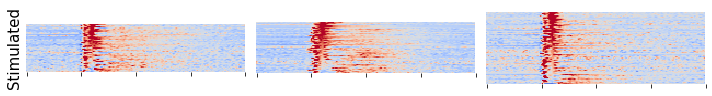

In [202]:
f, axes = plt.subplots(figsize=(10, 10), ncols=3, nrows=1, squeeze=True)

groups = ["chronic_saline", "citalopram_continuation", "citalopram_discontinuation"]

for i, ax in enumerate(axes):
    ax.imshow(stims.loc[lambda x: x.group_name == groups[i]].drop("group_name", axis=1), 
              cmap="coolwarm", vmin=-2.5, vmax=2.5)
    if i == 0:
        ax.set_ylabel("Stimulated", fontsize=15)
        
    ax.set_yticklabels([])
    ax.set_yticks([])

    ax.set(frame_on=False)
    ticks = np.array([0, 50, 100, 150, 200])
    ax.set_xticks(ticks)
    ax.set_xticklabels([])


plt.tight_layout()
plt.savefig(fig_dir / "psth_stimulated_heat.png", dpi=300, transparent=True)

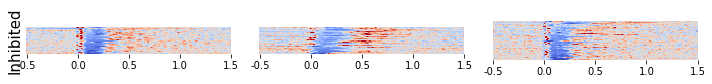

In [203]:
f, axes = plt.subplots(figsize=(10, 10), ncols=3, nrows=1, squeeze=True)


for i, ax in enumerate(axes):
    ax.imshow(inhibs.loc[lambda x: x.group_name == groups[i]].drop("group_name", axis=1), 
              cmap="coolwarm", vmin=-2.5, vmax=2.5)
    if i == 0:
        ax.set_ylabel("Inhibited", fontsize=15)
        
    ax.set_yticklabels([])
    ax.set_yticks([])

    ax.set(frame_on=False)
    ticks = np.array([0, 50, 100, 150, 200])
    ax.set_xticks(ticks)
    ax.set_xticklabels((ticks / 100) - 0.5)


plt.tight_layout()
plt.savefig(fig_dir / "psth_inhibited_heat.png", dpi=300, transparent=True)

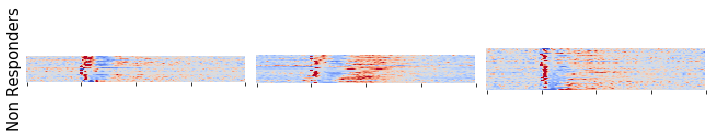

In [204]:
f, axes = plt.subplots(figsize=(10, 5), ncols=3, nrows=1, squeeze=True)


for i, ax in enumerate(axes):
    ax.imshow(non_responders.loc[lambda x: x.group_name == groups[i]].drop("group_name", axis=1), 
              cmap="coolwarm", vmin=-2.5, vmax=2.5)
    if i == 0:
        ax.set_ylabel("Non Responders", fontsize=15)
        
    ax.set_yticklabels([])
    ax.set_yticks([])

    ax.set(frame_on=False)
    ticks = np.array([0, 50, 100, 150, 200])
    ax.set_xticks(ticks)
    ax.set_xticklabels([])


plt.tight_layout()
plt.savefig(fig_dir / "psth_nr_heat.png", dpi=300, transparent=True)

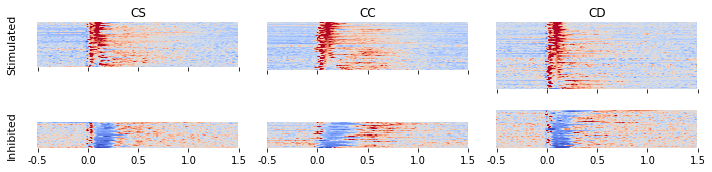

In [205]:
f, axes = plt.subplots(figsize=(10, 2.5), ncols=3, nrows=2, squeeze=True)

groups = ["chronic_saline", "citalopram_continuation", "citalopram_discontinuation"]
g_labels = ("CS", "CC", "CD")

for i, ax in enumerate(axes.flatten()):

    if i < 3:
        data = stims
    elif i <6:
        data = inhibs
    ax.imshow(data.loc[lambda x: x.group_name == groups[i % 3]].drop("group_name", axis=1), 
              cmap="coolwarm", vmin=-2.5, vmax=2.5)
    if i == 0:
        ax.set_ylabel("Stimulated", fontsize=11)
    elif i == 3:
        ax.set_ylabel("Inhibited", fontsize=11)
        

    ax.set(frame_on=False)


    # alignment
    if (i / len(groups)) < 1:
        ax.set_title(g_labels[i])
        ax.set_anchor("N")
    else:
        ax.set_anchor("S")
    
    # ticks
    ax.set_yticklabels([])
    ax.set_yticks([])
    xticks = np.array([0, 50, 100, 150, 200])
    ax.set_xticks(ticks)
    if (len(axes.flatten()) - i) <= len(groups):
        ax.set_xticklabels((ticks / 100) - 0.5)
    else:
        ax.set_xticklabels([])
    
    ax.yaxis.labelpad=20


plt.tight_layout()
plt.savefig(fig_dir / "psth_grid_heat.png", dpi=300, transparent=True)

### Plot Example PSTH

In [206]:
df_aligned = align_around_by(
            df_data=df_spikes.merge(dfb[["neuron_id", "session_name"]]).dropna(),
            df_data_data_colname="spiketimes",
            df_data_group_colname="session_name",
            df_events=df_events,
            df_events_event_colname="event_s",
            df_events_group_colname="session_name",
            max_latency=1.5,
            t_before=0.5).dropna()

In [207]:
inhibited_neurons = df_effects[df_effects["response_baseshock"] == "Inhibited"]["neuron_id"].values
inhibited_neuron = np.random.choice(inhibited_neurons, 1)[0]

In [208]:
inhibited_neuron = 2061

In [209]:
dfb[dfb["neuron_id"]==2061].cluster

993    slow_regular
Name: cluster, dtype: object

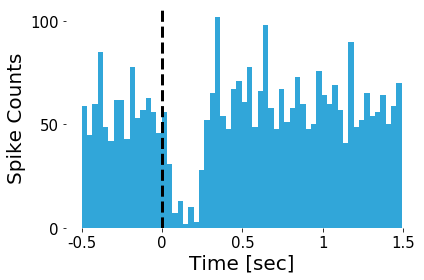

In [210]:
from spiketimes.df.binning import which_bin

f, ax = plt.subplots()

ax = which_bin(df_aligned[df_aligned["neuron_id"] == inhibited_neuron], bins[:-1], 
          spiketimes_col="aligned")["bin_values"].hist(bins=60, ax=ax, 
                                                       color="#31A6D9")

ax.grid(False)
ax.set(frame_on=False)

ax.set_yticks([0, 50, 100])
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.set_ylabel("Spike Counts", fontsize=20)

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5, 2], fontsize=15)

ax.set_xlabel("Time [sec]", fontsize=20)
ax = add_event_vlines(ax=ax, events=0, vline_kwargs={"linewidth": 3})

plt.tight_layout()
# plt.savefig(fig_dir /"psth_inhibited_actual.png", dpi=300, transparent=True)

In [211]:
excited_neuron = df_effects[df_effects["response_baseshock"] == "Stimulated"]["neuron_id"].values
excited_neuron = np.random.choice(excited_neuron, 1)[0]

In [212]:
excited_neuron=1317

In [213]:
excited_neuron

1317

In [214]:
dfb[dfb["neuron_id"]==excited_neuron].cluster

744    slow_regular
Name: cluster, dtype: object

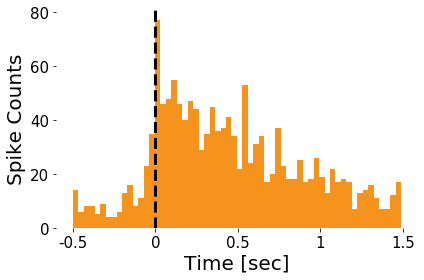

In [215]:
f, ax = plt.subplots()

ax = which_bin(df_aligned[df_aligned["neuron_id"] == excited_neuron], bins[:-1], 
          spiketimes_col="aligned")["bin_values"].hist(bins=60, ax=ax, 
                                                       color="#F6931D")

ax.grid(False)
ax.set(frame_on=False)

ax.set_yticks([0, 20, 40, 60, 80])
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.set_ylabel("Spike Counts", fontsize=20)

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5, 2], fontsize=15)

ax.set_xlabel("Time [sec]", fontsize=20)

ax = add_event_vlines(ax=ax, events=0, vline_kwargs={"linewidth": 3})

plt.tight_layout()
# plt.savefig(fig_dir / "psth_stimulated_actual.png", dpi=300, transparent=True)

## Save

In [218]:
(
    df_effects
    .merge(dfb[["neuron_id", "group_name", "session_name"]])
    .to_csv(data_dir / "baseshock_responses.csv", index=False)
)